In [1]:
%matplotlib inline

In [2]:
from clawpack.geoclaw import dtopotools
import numpy as np
from copy import copy
import matplotlib.pyplot as pl

### Rise fraction

New ``dtopotools.rise_fraction`` starts the rupture at ``subfault.rupture_time`` then the rupture is over ``subfault.rise_time`` seconds after that. (This is also ``dura`` field in the ``.rupt`` files.)

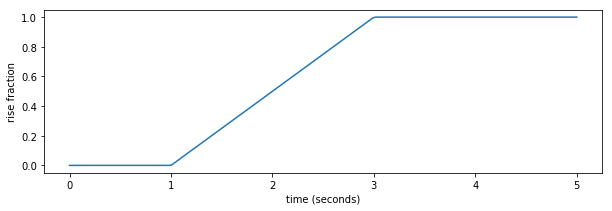

In [3]:
t_prev = -1.e99
t0 = 0.    # t0 is always 0
t1 = 1.    # rupture_time
t2 = 2.    # rise_time (duration of rupture)

t_array = np.linspace(0.,5.,200)
rf_array = np.zeros(t_array.shape)
for k,t in enumerate(t_array):
    rf = dtopotools.rise_fraction([t_prev,t],t0,t1,t2)
    rf_array[k] = rf[1]

pl.figure(figsize=(10,3))
pl.plot(t_array,rf_array);
pl.ylabel('rise fraction');
pl.xlabel('time (seconds)');

### Set up CSZ geometry

In [4]:
# read in .mshout (CSZ geoemetry)

cascadia = np.loadtxt('cascadia30.mshout',skiprows=1)
cascadia[:,[3,6,9,12]] = 1e3*abs(cascadia[:,[3,6,9,12]])

For example, the first triangular fault in the given geometry of CSZ has the nodes

In [5]:
print(cascadia[0,4:7])
print(cascadia[0,7:10])
print(cascadia[0,10:13])

[ -125.36073     46.302805  8795.382   ]
[  -125.311684     46.526803  10094.313   ]
[  -125.038743     46.426986  13526.373   ]


We now read in rupture scenario. [https://zenodo.org/record/59943#.WgHuahNSxE4]

We assume that the downloaded file is unzipped and placed in the current directory. (need access to ``Cascadia/data`` directory.)

In [6]:
# read in scenario
rupture_scenario_no = 1

rupt_fname_suffix = '{:0>6d}'.format(rupture_scenario_no)
rupt_fname = 'Cascadia/data/cascadia.' + rupt_fname_suffix \
                    + '/_cascadia.' + rupt_fname_suffix + '.rupt'
rupture_parameters = np.loadtxt(rupt_fname,skiprows=1)

### Compute seafloor deformations with GeoClaw 

We then set the GeoClaw dtopotools fault as follows:

In [7]:
fault0 = dtopotools.Fault()
fault0.subfaults = []
fault0.rupture_type = 'dynamic'
rake = 90.
slip = 1.

J = int(np.floor(cascadia.shape[0]))

for j in range(J):
    subfault0 = dtopotools.SubFault()
    node1 = cascadia[j,4:7].tolist()
    node2 = cascadia[j,7:10].tolist()
    node3 = cascadia[j,10:13].tolist()
    node_list = [node1,node2,node3]
    
    ss_slip = rupture_parameters[j,8]
    ds_slip = rupture_parameters[j,9]
    
    rake = np.rad2deg(np.arctan2(ds_slip, ss_slip))
    
    subfault0.set_corners(node_list,rake=rake,projection_zone='10T')
    subfault0.rupture_time = rupture_parameters[j,12]
    subfault0.rise_time = rupture_parameters[j,7]
    

    slip = np.sqrt(ds_slip ** 2 + ss_slip ** 2)
    subfault0.slip = slip
    fault0.subfaults.append(subfault0)

Then run the ``create_dtopography`` routine to generate dynamic seafloor deformations at given times

In [8]:
lims = [cascadia[:,1].min(),cascadia[:,1].max(),cascadia[:,2].min(),cascadia[:,2].max()]

x0 = lims[0]-1.
x1 = lims[1]+1.

y0 = lims[2]-1.
y1 = lims[3]+1.

x = np.linspace(x0,x1,100)
y = np.linspace(y0,y1,100)

tfinal = max([subfault1.rupture_time + subfault1.rise_time for subfault1 in fault0.subfaults])
times0 = np.linspace(0.,tfinal,100)
dtopo0 = fault0.create_dtopography(x,y,times=times0);

/Users/dsrim/local/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1298: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/Users/dsrim/local/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1303: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


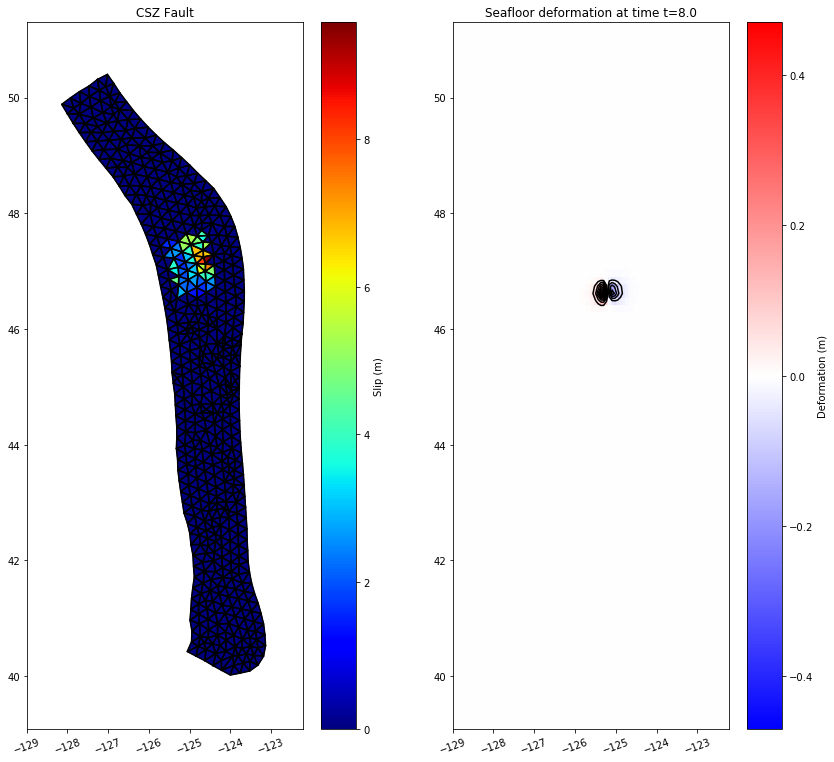

In [9]:
to = 8.    # time to plot deformation

fig,(ax0,ax1) = pl.subplots(ncols=2,nrows=1,figsize=(14,13))
fault0.plot_subfaults(axes=ax0,slip_color=True);
ax0.set_xlim([x0,x1])
ax0.set_ylim([y0,y1])
ax0.set_title('CSZ Fault');
dtopo0.plot_dZ_colors(to,axes=ax1);
ax1.set_title('Seafloor deformation at time t=' + 'str'(to));
fig.savefig('CSZ_triangular.png')


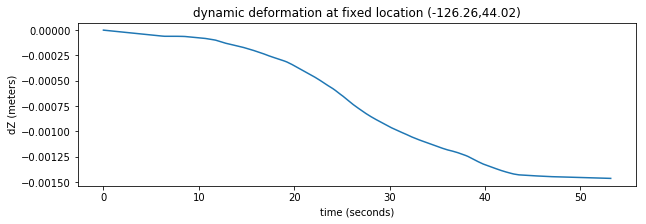

In [10]:
t_list = np.linspace(0.,tfinal,200)

j = 40
k = 40
a = [dtopo0.dZ_at_t(t0)[40,40] for t0 in t_list]

pl.figure(figsize=(10,3))
pl.title('dynamic deformation at fixed location (' + '{:4.2f}'.format(x[j]) \
                                             + ',' + '{:4.2f}'.format(y[k]) + ')' )
pl.plot(t_list,a);
pl.ylabel('dZ (meters)');
pl.xlabel('time (seconds)');